In [1]:
import src.models_and_optimizers as model_utils
import yaml
from types import SimpleNamespace
from clip_main import get_wds_loaders
from transformers import EsmTokenizer
import src.data_utils as data_utils
import os
import torch
import sys
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import json
from torch.cuda.amp import autocast
from scipy.stats.stats import pearsonr 
import matplotlib.pyplot as plt
import yaml

import webdataset as wds

2023-12-04 16:38:51.696713: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-04 16:38:52.549155: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_2874082/1988170119.py:16: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [19]:
model_dir = "rla_model/version_0"
path = os.path.join(model_dir, "checkpoints/checkpoint_latest.pt")
data_root = "example_decoy/wds"
args_path = os.path.join(model_dir, 
                         [u for u in os.listdir(model_dir) if u.endswith('.pt')][0])

In [33]:
hparams = torch.load(args_path)
hparams['args']['blacklist_file'] = "pdb_blacklist.txt"
hparams['args']['coordinator_hparams'] = "terminator_configs/standard.json"
args_dict = hparams['args']
args_dict['batch_size'] = 50
args_dict['distributed'] = 0

args_dict['train_wds_path'] = 'wds_decoy'
args_dict['val_wds_path'] = 'wds_decoy'
args_dict['data_root'] = "/mnt/xfs/projects/proteins/decoy/decoy_data/decoys"

args = SimpleNamespace(**args_dict)
coordinator_params = data_utils.get_coordinator_params(args.coordinator_hparams)
coordinator_params['num_positional_embeddings'] = args.gnn_num_pos_embs
coordinator_params['zero_out_pos_embs']= args.gnn_zero_out_pos_embs
coordinator_params['clip_mode'] = True

In [34]:
trained_model = model_utils.load_model(path, 'cuda')
tokenizer = EsmTokenizer.from_pretrained(args_dict['arch'])

loading state dict from rla_model/version_0/checkpoints/checkpoint_latest.pt
building model based on path


Some weights of the model checkpoint at facebook/esm2_t30_150M_UR50D were not used when initializing EsmModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing EsmModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


ZERO OUT POS EMB False
GNN Potts Model Encoder hidden dimensionality is 128
freeze_llm False
{'training_args': {'epochs': 10, 'lr': 0.001, 'weight_decay': 0.001, 'momentum': 0.9, 'label_smoothing': 0.0, 'lr_peak_epoch': 2, 'eval_epochs': 2, 'only_non_bn_weight_decay': False, 'opt': 'ADAM', 'lr_scheduler': 'cosine', 'burn_in': 0, 'mixed_precision': True, 'max_len': 1024, 'self_supervised': True}, 'epoch': 9, 'training_metrics': {'loss': 0.6333152562079322, 'acc': 0.6356185298161776}, 'val_metrics': {'loss': 1.6227540006807477, 'acc': 0.5308778800395427}, 'model_building_args': {'esm_arch': 'facebook/esm2_t30_150M_UR50D', 'terminator_hparams': {'cov_features': 'all_raw', 'cov_compress': 'project', 'term_use_mpnn': True, 'matches': 'transformer', 'energies_style': 'mpnn', 'energies_use_mpnn': True, 'energies_full_graph': True, 'contact_idx': True, 'energies_encoder_layers': 3, 'energies_hidden_dim': 128, 'resnet_linear': True, 'matches_linear': True, 'transformer_linear': True, 'term_mpnn

In [35]:
def get_text_and_image_features(model, tokenizer, batch):
    seq_batch, coords_batch = batch
    seqs = seq_batch['string_sequence']
    text_inp = tokenizer(seqs, return_tensors='pt', padding=True, truncation=True, max_length=1024+2)
    text_inp['position_ids'] = seq_batch['pos_embs'][0]
    text_inp = {k: v.to('cuda') for k, v in text_inp.items()}
    coord_data = data_utils.construct_gnn_inp(coords_batch, device='cuda', half_precision=True)
    gnn_features, text_features, logit_scale = model(text_inp, coord_data)
    new_text_features, _, new_text_mask = data_utils.postprocess_text_features(
        text_features=text_features, 
        inp_dict=text_inp, 
        tokenizer=tokenizer, 
        placeholder_mask=seq_batch['placeholder_mask'][0])
    return {
        'text': new_text_features, # text feature
        'gnn': gnn_features, # gnn feature
        'seq_mask_with_burn_in': seq_batch['seq_loss_mask'][0], # sequence mask of what's supervised
        'coord_mask_with_burn_in': coords_batch['coords_loss_mask'][0], # coord mask of what's supervised
        'seq_mask_no_burn_in': new_text_mask.bool(), # sequence mask of what's valid (e.g., not padded)
        'coord_mask_no_burn_in': coords_batch['coords'][1], # coord mask of what's valid
    }

In [36]:
decoys = ['1a32', '1aaj']

running on  1a32
{'max_coords_len': 2000, 'shuffle_coords': False, 'max_seq_len': 1024, 'pos_offset': 128, 'burn_in': 0, 'k_neighbors': 30, 'crop_type': 'absolute', 'shuffle_chains': False, 'num_mutations': -1, 'masked_rate': -1.0, 'masked_mode': 'MASK'}
added select filtering... 30
0 0


20it [00:03,  6.29it/s]


0.9493443825192727


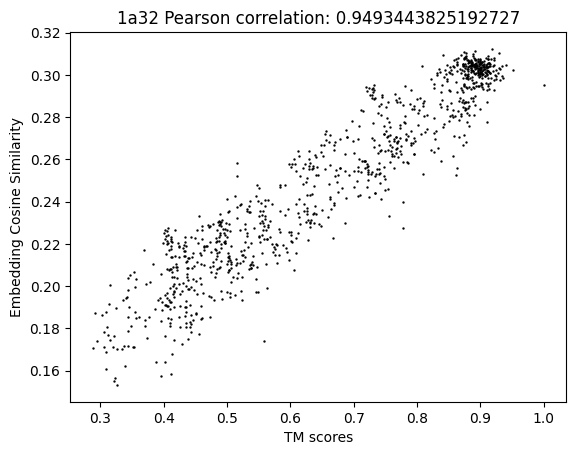

running on  1aaj
{'max_coords_len': 2000, 'shuffle_coords': False, 'max_seq_len': 1024, 'pos_offset': 128, 'burn_in': 0, 'k_neighbors': 30, 'crop_type': 'absolute', 'shuffle_chains': False, 'num_mutations': -1, 'masked_rate': -1.0, 'masked_mode': 'MASK'}
added select filtering... 30
0 0


1it [00:01,  1.13s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fee3ab91e50>
Traceback (most recent call last):
  File "/mnt/xfs/home/saachij/conda_envs/bio_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/mnt/xfs/home/saachij/conda_envs/bio_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/mnt/xfs/home/saachij/conda_envs/bio_env/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
33it [00:06,  4.97it/s]


0.9332214502444536


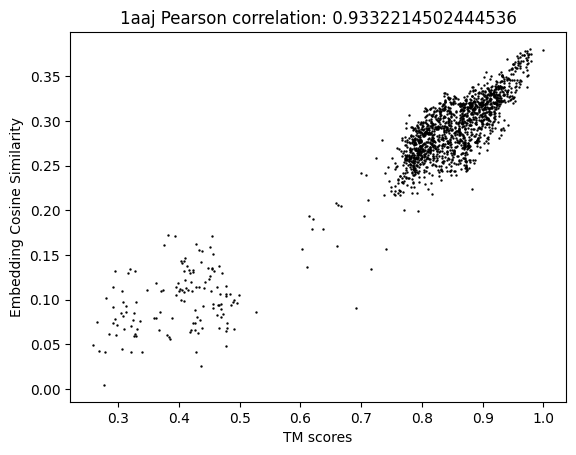

In [39]:
for decoy in decoys:
    print("running on ", decoy)
    
    ## Calculate TM score to native (or load if pre-calculated)
    out_path = os.path.join("example_decoy/TM_scores",decoy + 'scores.json')
    with open(out_path, 'r') as f:
        TM_scores = json.load(f)
    TM_scores = np.array(list(TM_scores.values()))
    TM_scores = np.array(TM_scores)
    
    args.train_wds_path = "wds_decoy" + decoy + '.tar'
    args.val_wds_path = "wds_decoy" + decoy + '.tar'
    train_loader, val_loader, train_len, val_len = get_wds_loaders(args, coordinator_params, gpu=None, shuffle_train=False, val_only=True, return_count=False)

    all_scores = []
    for i, batch in enumerate(tqdm(val_loader, total=val_len)):
        with torch.no_grad():
            with autocast(dtype=torch.float16):
                output_dict = get_text_and_image_features(trained_model, tokenizer, batch)
                text_feat = output_dict['text']
                gnn_feat =  output_dict['gnn'][:, :text_feat.shape[1]] # remove tail padding
                scores = (text_feat.unsqueeze(2) @ gnn_feat.unsqueeze(-1)).squeeze(-1).squeeze(-1)
                scores = (scores * output_dict['seq_mask_no_burn_in'].float()).sum(1)/output_dict['seq_mask_no_burn_in'].sum(1)
                all_scores.append(scores.cpu())
    all_sims_list = torch.cat(all_scores).numpy()
     
    
    ## Plot results
    if len(TM_scores) != len(all_sims_list):
        print("Length issue with ", decoy)
        continue
    nas = np.logical_or(np.isnan(TM_scores), np.isnan(all_sims_list))
    corr = pearsonr(TM_scores[~nas], all_sims_list[~nas])[0]
    print(corr)
    fig = plt.figure()
    plt.scatter([TM_scores], all_sims_list, c= "k", s= 0.5)
    plt.xlabel('TM scores')
    plt.ylabel('Embedding Cosine Similarity')
    plt.title(decoy + ' Pearson correlation: ' + str(corr))
#     plt.savefig(os.path.join(decoy_folder, decoy + '_correlation.png'))
    plt.show()
    

In [30]:
coordinator_params

{'cov_features': 'all_raw',
 'cov_compress': 'project',
 'term_use_mpnn': True,
 'matches': 'transformer',
 'energies_style': 'mpnn',
 'energies_use_mpnn': True,
 'energies_full_graph': True,
 'contact_idx': True,
 'energies_encoder_layers': 3,
 'energies_hidden_dim': 128,
 'resnet_linear': True,
 'matches_linear': True,
 'transformer_linear': True,
 'term_mpnn_linear': True,
 'use_terms': False,
 'res_embed_linear': True,
 'model': 'multichain',
 'term_hidden_dim': 32,
 'gradient_checkpointing': True,
 'num_pair_stats': 28,
 'num_sing_stats': 0,
 'resnet_blocks': 4,
 'term_layers': 4,
 'term_heads': 4,
 'conv_filter': 3,
 'matches_layers': 4,
 'matches_num_heads': 4,
 'k_neighbors': 30,
 'k_cutoff': None,
 'cie_dropout': 0.1,
 'cie_scaling': 500,
 'cie_offset': 0,
 'transformer_dropout': 0.1,
 'energies_protein_features': 'full',
 'energies_augment_eps': 0,
 'energies_dropout': 0.1,
 'energies_output_dim': 400,
 'energies_gvp': False,
 'struct2seq_linear': False,
 'use_coords': True,
